From http://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
np.random.seed(123)
alpha, sigma = 1, 1
beta = [1, 2.5]
size = 100
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

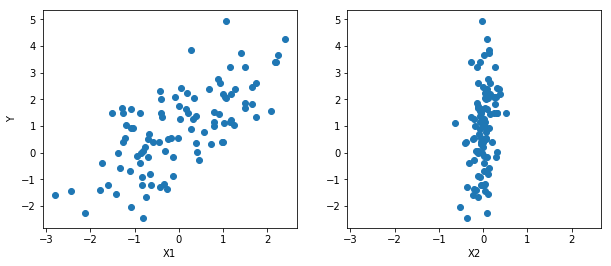

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## Fit the data

In [6]:
import pymc3 as pm

### Specify the model

In [7]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

### Maximum a posteriori methods

In [10]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|█████| 19/19 [00:00<00:00, 1217.93it/s]


{'alpha': array(0.9066009314912588),
 'beta': array([ 0.94848596,  2.60711845]),
 'sigma': array(0.9629885768973849),
 'sigma_log__': array(-0.03771372925085054)}

### Sampling

In [12]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████| 1000/1000 [00:01<00:00, 781.74it/s]


In [16]:
trace["alpha"].shape, trace["beta"].shape

((500,), (500, 2))

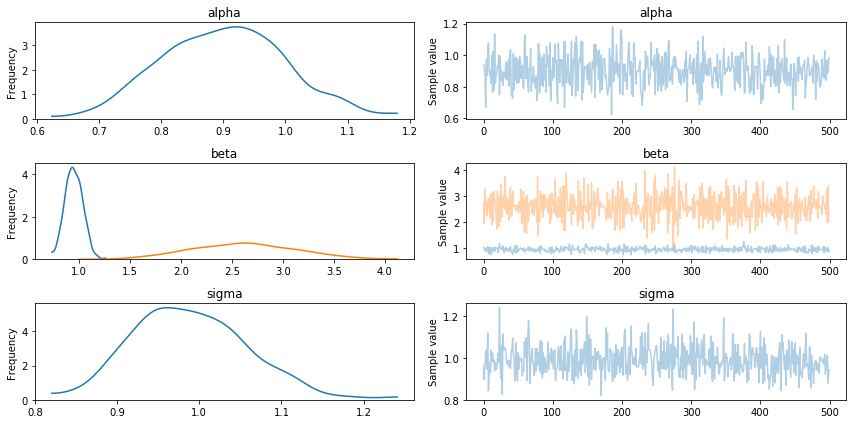

In [14]:
_ = pm.traceplot(trace)

In [17]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.900            0.098            0.003            [0.729, 1.098]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.715          0.827          0.902          0.969          1.089


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.951            0.085            0.003            [0.789, 1.106]
  2.612            0.507            0.015            [1.677, 3.578]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.792          0.889          0.946          1.010          1.111
  1.682          2.227          2.610   

## Mining disasters

Shows how to handle missing data, and the `switch` command.

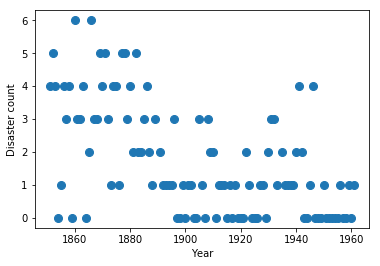

In [20]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")
None

In [21]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [22]:
with disaster_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|███████████████████████████████████| 10500/10500 [01:10<00:00, 149.90it/s]


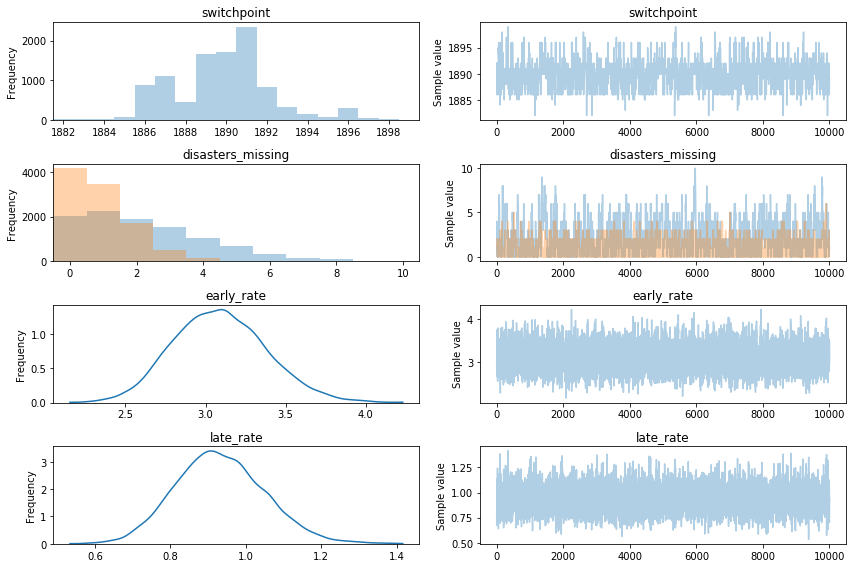

In [24]:
_ = pm.traceplot(trace)